# Import Libraries

In [1]:
import requests # to get the html markdown from the url
from bs4 import BeautifulSoup # to make the html readable
import pandas as pd # to save table in a csv
from datetime import datetime # to append current time into file name


# Get the data from website

In [2]:
url_surplus = 'https://web.byui.edu/SurplusList/'
html_data = requests.get(url_surplus)
soup = BeautifulSoup(html_data.text, 'html.parser')


# Build Table

In [3]:
rows=[]
for item in soup.find_all('tr')[13:]:
    row={}
    row['Item Number'] = item.select('td')[0].text
    row['Qty'] = item.select('td')[1].text
    row['Description'] = item.select('td')[2].text
    row['Condition'] = item.select('td')[3].text
    row['Price'] = item.select('td')[4].text
    row['Location'] = item.select('td')[5].text
    row['Quick/Bid'] = item.select('td')[6].text
    row['Image'] = item.select('td')[7].text
    rows.append(row)


In [57]:
data = pd.DataFrame(rows)
data

,Item Number,Qty,Description,Condition,Price,Location,Quick/Bid,Image
0,77056,1,"2013 27"" iMac",FAIR,$300.00,EA,Quick,
1,77047,1,"2017 Chevrolet Colorado ex cab 2wd, 2.5 auto e...",GOOD,"$21,995.00",EA,Bid,
2,75298,1,22 Oz Stainless Steel Top Water Bottle (Blue/P...,GOOD,$0.50,EA,Quick,Image
3,75668,5,5' storage/file cabinet,GOOD,$5.00,EA,Quick,
4,73180,1,8-Pack Verbatim Brand Blank Logo CD-R CDR 80,POOR,$0.25,AMT,Quick,Image
...,...,...,...,...,...,...,...,...
145,74385,1,Urban Expressions Gold Crossbody Bag,GOOD,$0.50,EA,Quick,Image
146,52769,59,VGA Cables,GOOD,$1.00,EA,Quick,Image
147,74697,1,White Neewer 2.4 GHz Wireless Remote in box or...,EXCELLENT,$1.25,EA,Quick,Image
148,75306,1,Zeroxposur Jacket for Man Size XXL (Black),GOOD,$1.75,EA,Quick,Image


## Save to CSV 

In [6]:
date = datetime.now().strftime("%d-%m-%Y %H%M%S") # get local time as string

filePath = "../Surplus - Historical Data/SurplusSaleItems " + date + " - Webscrape.csv"

data.to_csv(filePath, index=False) # save to file path

## Simple Data Analysis 

In [25]:
import matplotlib.pyplot as plt
import plotly.express as px

In [58]:
data.drop(data.tail(1).index,inplace=True) # Drop last row (is empty)
data.describe()

,Item Number,Qty,Description,Condition,Price,Location,Quick/Bid,Image
count,149,149,149,149,149,149,149,149
unique,149,19,122,6,43,4,2,2
top,76752,1,Cisco 6500 series chassis,GOOD,$50.00,EA,Quick,Image
freq,1,122,28,111,33,115,142,94


In [59]:
# Change column data types
data.Price = pd.to_numeric(data.Price.str.replace("$","",regex=True).replace(",","",regex=True))
data['Item Number'] = pd.to_numeric(data['Item Number'])
data.Qty = pd.to_numeric(data.Qty)
data.Condition = data.Condition.str.capitalize()
a = data.copy()

# repeat rows based on quantity
data = data.reindex(data.index.repeat(data.Qty)).reset_index().drop(['index','Qty'], axis=1)


CONDITION OF ITEMS

PLOT: ITEMS BASED ON CONDITION



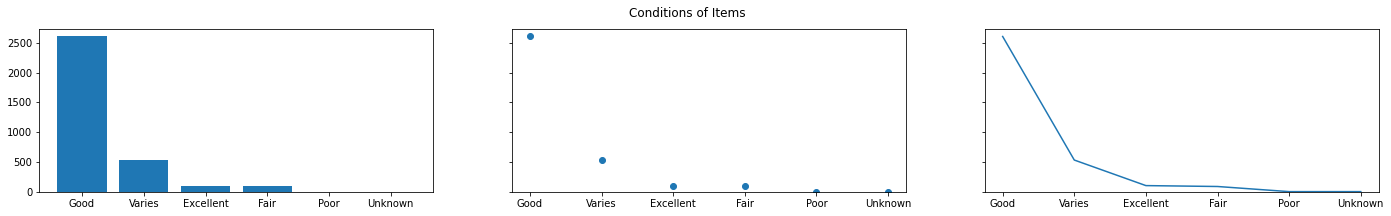

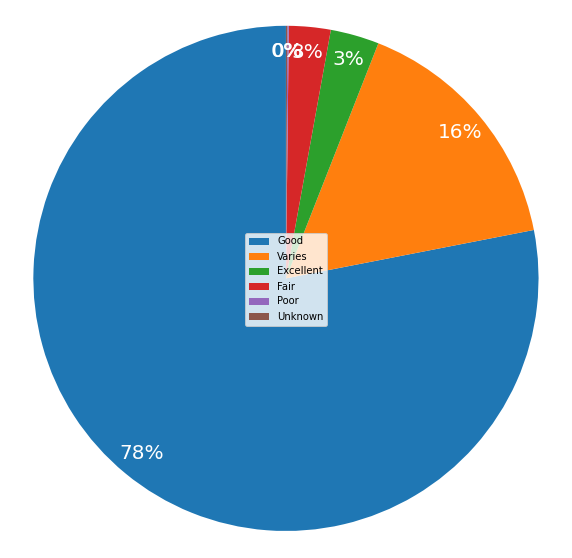

In [71]:
print(
"""
CONDITION OF ITEMS

PLOT: ITEMS BASED ON CONDITION
"""
)

names = data['Condition'].value_counts().reset_index()['index']
values = data['Condition'].value_counts().reset_index()['Condition']

fig, axs = plt.subplots(1, 3, figsize=(24, 3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Conditions of Items')

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(values, autopct='%1.0f%%', startangle=90,textprops={'color':"w",'fontsize': 20},pctdistance=0.9)
ax1.axis('equal')
plt.legend(names, loc="center")

fig = px.bar(
    a,
    # y='Price',
    x='Condition',
    color='Condition',
    color_discrete_map={'Good':'green','Fair':'gray','Excellent':'gold','Poor':'red'},
    title="ITEMS PER CONDITION",
    width=1200, height=400
    )

fig.update_layout(xaxis={'categoryorder':'total descending'})

fig.show()


In [72]:
print('TABLE: ITEMS AMOUNT PER CONDITION')
data['Condition'].value_counts()

TABLE: ITEMS AMOUNT PER CONDITION


Good         2606
Varies        533
Excellent     104
Fair           89
Poor            3
Unknown         3
Name: Condition, dtype: int64

In [42]:
# Top 10 expensive items - overall
print(
"""
TOP 10 MOST EXPENSIVE ITEMS
"""
)

a = data.sort_values('Price',ascending=False).head(10)[['Description','Price','Condition']].reset_index().drop('index',axis=1)
a


TOP 10 MOST EXPENSIVE ITEMS



,Description,Price,Condition
0,"2017 Chevrolet Colorado ex cab 2wd, 2.5 auto e...",21995.00,Good
1,"Electrolux Professional Ag, Ch-6210 Sursee Til...",17500.00,Good
2,Dakota turf tender 440,16000.00,Excellent
3,Morgana Digifold Pro Folding/Scoring Machine,7500.00,Fair
4,Gray Wheel lift model wl30,3495.00,Excellent
5,Electric Pie Press with extras,3000.00,Good
6,Ice Dispenser,768.75,Good
7,BKI Free Standing Fry Dump Station or Food Wa...,700.00,Good
8,Sports O Zone Machine,500.00,Good
9,Labconco Paramount Filtered Enclosure stand,500.00,Excellent


In [43]:
# Top 10 expensive items - overall
print(
"""
TOP 10 MOST EXPENSIVE ITEMS
"""
)

fig = px.bar(
    a,
    y='Description',
    x='Price',
    color='Condition',
    color_discrete_map={'Good':'green','Fair':'gray','Excellent':'gold'},
    orientation='h',
    title="TOP 10 MOST EXPENSIVE ITEMS",
    width=1200, height=400
    )

# fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.show()


TOP 10 MOST EXPENSIVE ITEMS



In [44]:
# Bottom 10 cheapest items - overall

print('TOP 10 CHEAPEST ITEMS')


a = data.sort_values('Price',ascending=False).tail(10)[['Description','Price','Condition']].reset_index().drop('index',axis=1)
a

TOP 10 CHEAPEST ITEMS


,Description,Price,Condition
0,Candy skull black and red headphones,0.50,Good
1,Black Sunglasses,0.50,Good
2,Black Sunglasses,0.50,Good
3,Black Cat-eye Sunglasses,0.50,Good
4,Aviator Sunglasses,0.50,Good
5,22 Oz Stainless Steel Top Water Bottle (Blue/P...,0.50,Good
6,Urban Expressions Gold Crossbody Bag,0.50,Good
7,8-Pack Verbatim Brand Blank Logo CD-R CDR 80,0.25,Poor
8,Silver Ring with Stars Around It Size 10,0.25,Good
9,Stars golden bracelet,0.12,Good


In [48]:
# Bottom 10 expensive items - overall

print('TOP 10 CHEAPEST ITEMS')

fig = px.bar(
    a,
    y='Description',
    x='Price',
    color='Condition',
    color_discrete_map={'Good':'green','Fair':'gray','Excellent':'gold','Poor':'red'},
    orientation='h',
    title='TOP 10 CHEAPEST ITEMS',
    width=1200, height=400
    )

# fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.show()

TOP 10 CHEAPEST ITEMS


In [237]:
# Top 10 highest price items - with Excellent condition

print('Top 10 highest price items - with Excellent condition')

data[
    (~data.Description.duplicated()) & # remove duplicates
    (data.Condition == 'EXCELLENT') # filter by condition = Excellent
].sort_values('Price',ascending=False).head(10)[ # top 10
    ['Description','Price','Condition'] # select columns 
].reset_index().drop('index',axis=1) # reset index

Top 10 highest price items - with Excellent condition


,Description,Price,Condition
0,Dakota turf tender 440,16000.00,EXCELLENT
1,Gray Wheel lift model wl30,3495.00,EXCELLENT
2,Labconco Paramount Filtered Enclosure stand,500.00,EXCELLENT
3,Sold by the case furnace filters,8.00,EXCELLENT
4,OIC 2 unit stackable Wall File System,3.00,EXCELLENT
5,Book The Good Guide by Alison L Grinder,1.25,EXCELLENT
6,White Neewer 2.4 GHz Wireless Remote in box or...,1.25,EXCELLENT
7,"Coin Boxes - Pennies, Nickels, Dimes",0.75,EXCELLENT


In [234]:
# Top 10 higest price items - with Good condition

print('Top 10 higest price items - with \'Good\' condition \n')

data[
    (~data.Description.duplicated()) & # remove duplicates
    (data.Condition == 'GOOD') # filter by condition = Excellent
].sort_values('Price',ascending=False).head(10)[ # top 10
    ['Description','Price','Condition'] # select columns 
].reset_index().drop('index',axis=1) # reset index


Top 10 higest price items - with 'Good' condition 



,Description,Price,Condition
0,"2017 Chevrolet Colorado ex cab 2wd, 2.5 auto e...",21995.00,GOOD
1,"Electrolux Professional Ag, Ch-6210 Sursee Til...",17500.00,GOOD
2,Electric Pie Press with extras,3000.00,GOOD
3,Ice Dispenser,768.75,GOOD
4,BKI Free Standing Fry Dump Station or Food Wa...,700.00,GOOD
5,Sports O Zone Machine,500.00,GOOD
6,Duke Tray Warmer,243.75,GOOD
7,Dual Drawer Toast Master,180.00,GOOD
8,Chick-fil-A Sandwich and Fry Display,121.25,GOOD
9,Fry Catch Basin,118.75,GOOD


In [104]:
# If they were to sell all the items, how much money would they have?

all_items = "${:,.2f}".format(data.Price.sum())
excellent_items = "${:,.2f}".format(data[data.Condition=='Excellent']['Price'].sum())
good_items = "${:,.2f}".format(data[data.Condition=='Good']['Price'].sum())
fair_items = "${:,.2f}".format(data[data.Condition=='Fair']['Price'].sum())
poor_items = "${:,.2f}".format(data[data.Condition=='Poor']['Price'].sum())
varies_items = "${:,.2f}".format(data[data.Condition=='Varies']['Price'].sum())
unknown_items = "${:,.2f}".format(data[data.Condition=='Unknown']['Price'].sum())

print(f"""
IF WERE TO SELL ALL ITEMS

Sell from all items:\t\t{all_items}

Sell from Excellent items:\t{excellent_items}
Sell from Good items:\t\t{good_items}
Sell from Fair items:\t\t{fair_items}
Sell from Poor items:\t\t{poor_items}
Sell from Varies items:\t\t{varies_items}
Sell from Unknown items:\t{unknown_items}
""")



IF WERE TO SELL ALL ITEMS

Sell from all items:		$89,407.87

Sell from Excellent items:	$20,204.50
Sell from Good items:		$53,600.12
Sell from Fair items:		$14,856.25
Sell from Poor items:		$50.75
Sell from Varies items:		$533.00
Sell from Unknown items:	$163.25

